## Imports and EDA

In [294]:
# !pip install feature_engine
# !pip install catboost
# !pip install TPOT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
%matplotlib inline

import scipy.stats as stats
import pylab

from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score

from catboost import CatBoostRegressor
import xgboost as xgb
from tpot import TPOTRegressor

import warnings
warnings.filterwarnings('ignore')
from google.colab import files

In [313]:
df_train = pd.read_csv('train_v9rqX0R.csv')
df_test = pd.read_csv('test_AbJTz2l.csv')
df_sample = pd.read_csv('sample_submission_8RXa3c6.csv')

In [9]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


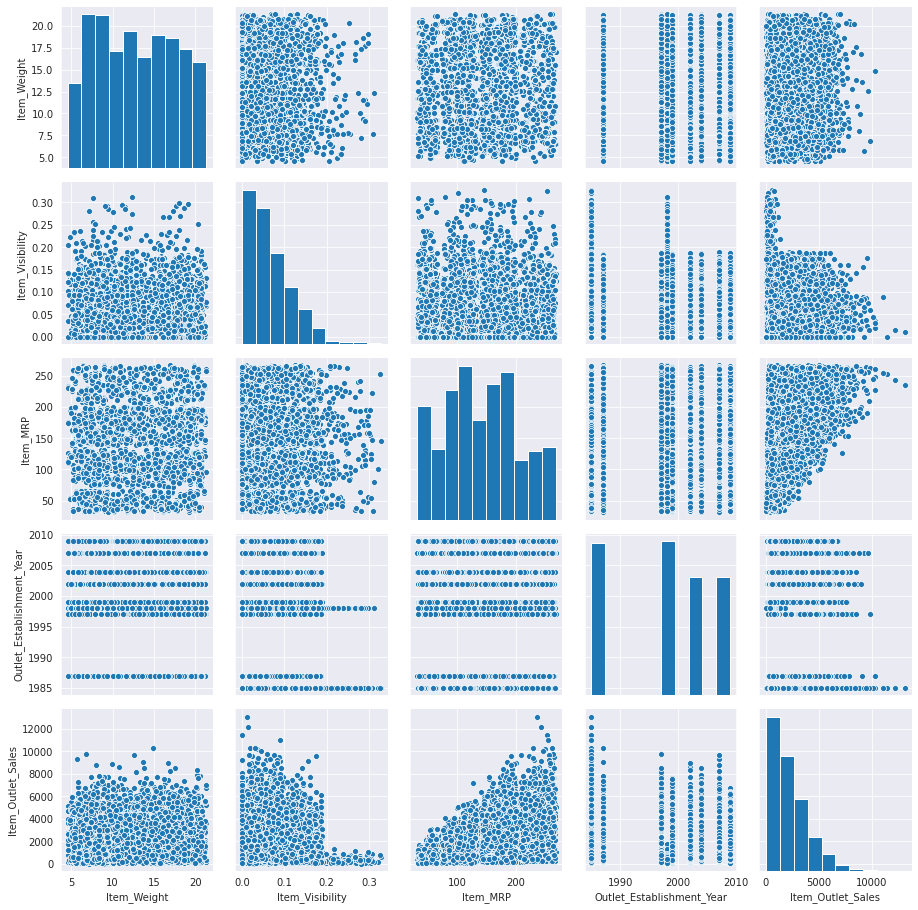

In [38]:
sns.pairplot(df_train)

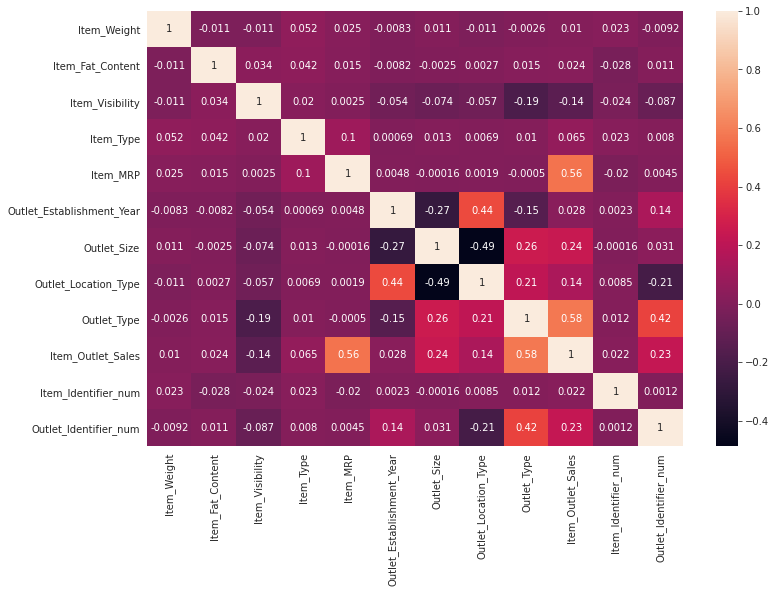

In [102]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(),annot=True)

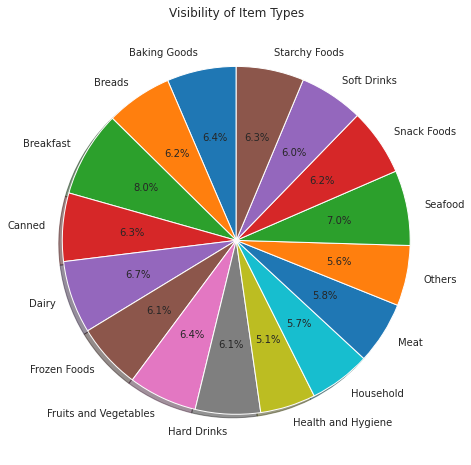

In [349]:
plt.figure(figsize=(15,8))
pie = df_train.groupby('Item_Type')['Item_Visibility'].mean().reset_index()
plt.pie(x = pie['Item_Visibility'],labels = pie['Item_Type'],rotatelabels=False,autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Visibility of Item Types')
plt.show()

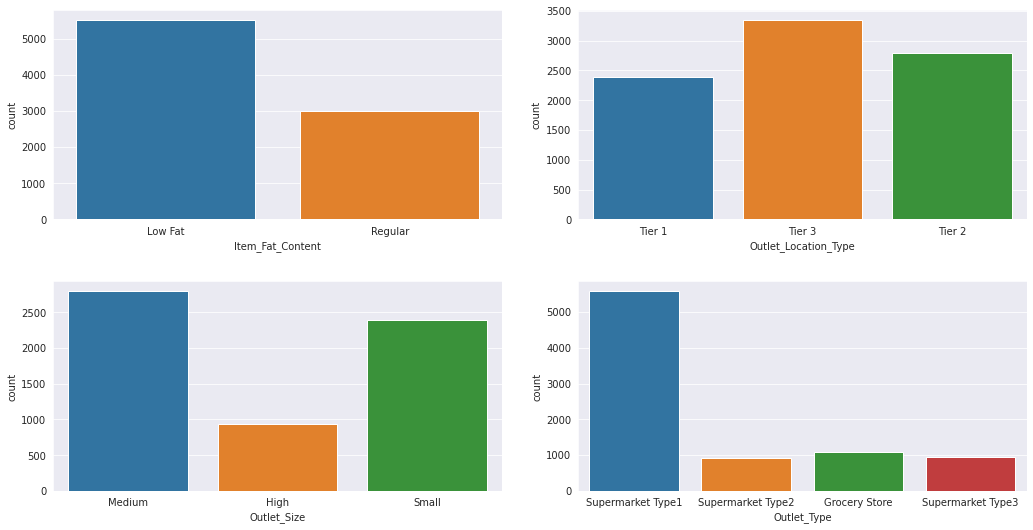

In [348]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
sns.countplot('Item_Fat_Content',data = df_train)
plt.subplot(2,2,2)
sns.countplot('Outlet_Location_Type',data = df_train)
plt.subplot(2,2,3)
sns.countplot('Outlet_Size',data = df_train)
plt.subplot(2,2,4)
sns.countplot('Outlet_Type',data = df_train)
plt.tight_layout(pad = 3)

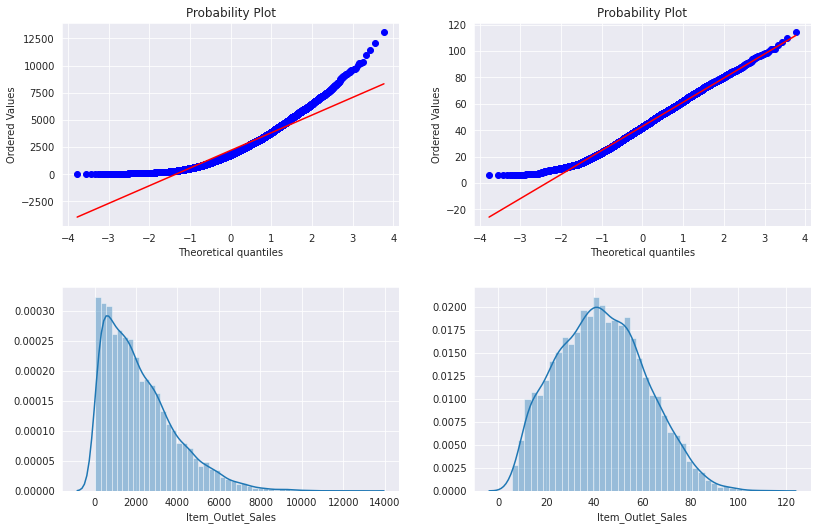

In [88]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(df_train['Item_Outlet_Sales'],plot = pylab)
plt.subplot(2,2,2)
stats.probplot(np.sqrt(df_train['Item_Outlet_Sales']),plot = pylab)
plt.subplot(2,2,3)
sns.distplot(df_train['Item_Outlet_Sales'])
plt.subplot(2,2,4)
sns.distplot(np.sqrt(df_train['Item_Outlet_Sales']))
plt.tight_layout(pad=3)

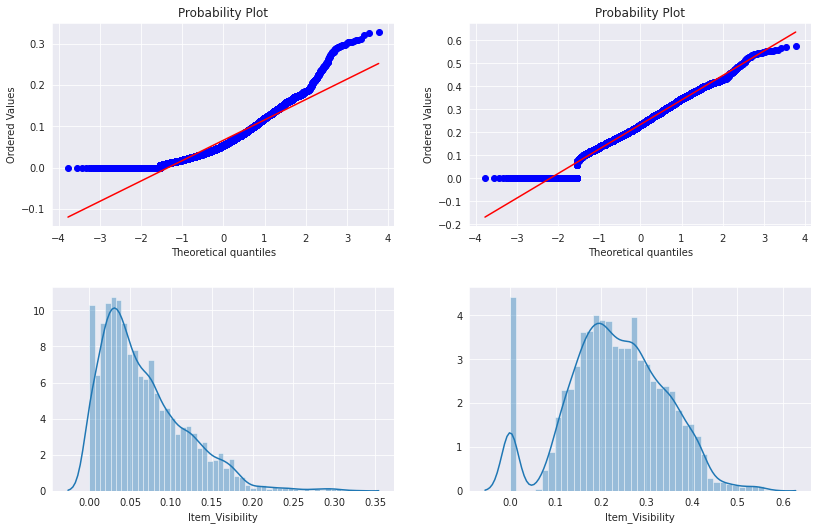

In [89]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(df_train['Item_Visibility'],plot = pylab)
plt.subplot(2,2,2)
stats.probplot(np.sqrt(df_train['Item_Visibility']),plot = pylab)
plt.subplot(2,2,3)
sns.distplot(df_train['Item_Visibility'])
plt.subplot(2,2,4)
sns.distplot(np.sqrt(df_train['Item_Visibility']))
plt.tight_layout(pad=3)

In [10]:
df_train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [280]:
drop_list = ['Item_Identifier','Outlet_Identifier']
num_mean = ['Item_Weight']
cat_missing = ['Outlet_Size']
cat_ohe = ['Item_Fat_Content','Item_Type','Outlet_Type','Outlet_Location_Type','Outlet_Size','Item_Identifier_cat']
num_skewed=['Item_MRP','Item_Visibility']

In [281]:
df_train['Item_Identifier_cat'] = df_train['Item_Identifier'].apply(lambda x:x[0:3])
df_train['Item_Identifier_num'] = df_train['Item_Identifier'].apply(lambda x:x[3:5]).astype('int')
df_train['Outlet_Identifier_num'] = df_train['Outlet_Identifier'].apply(lambda x:x[3:6]).astype(int)

df_test['Item_Identifier_cat'] = df_test['Item_Identifier'].apply(lambda x:x[0:3])
df_test['Item_Identifier_num'] = df_test['Item_Identifier'].apply(lambda x:x[3:5]).astype('int')
df_test['Outlet_Identifier_num'] = df_test['Outlet_Identifier'].apply(lambda x:x[3:6]).astype(int)

In [337]:
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace('LF','Low Fat') 
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace('low fat','Low Fat')
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace('reg','Regular') 

df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace('LF','Low Fat') 
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace('low fat','Low Fat')
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace('reg','Regular')   

In [283]:
df_train['Item_Visibility'] = np.sqrt(df_train['Item_Visibility'])

df_test['Item_Visibility'] = np.sqrt(df_test['Item_Visibility'])

In [285]:
df_train.drop(drop_list,axis =1,inplace=True)

df_test.drop(drop_list,axis =1,inplace = True)

In [286]:
pipe = Pipeline([
                 ('mean', mdi.MeanMedianImputer(imputation_method='mean',variables = num_mean)),
                 ('vt', vt.YeoJohnsonTransformer(variables = num_skewed)),
                 ('missing', mdi.CategoricalVariableImputer(variables=cat_missing)),
                #  ('ordenc', ce.OrdinalCategoricalEncoder(variables=cat_ohe))
                ('ohe',ce.OneHotCategoricalEncoder(drop_last=True,variables=cat_ohe))
])

In [287]:
X = df_train.drop('Item_Outlet_Sales',axis =1)
y = df_train['Item_Outlet_Sales']
X = pipe.fit_transform(X)
df_test = pipe.transform(df_test)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [289]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
df_test = scale.transform(df_test)

## TPOT 

In [23]:
tp = TPOTRegressor(verbosity = 2, generations=7, population_size=100)
tp.fit(X_train,y_train)
pred_tpot = tp.predict(X_test)
print('Root Mean Squared Error',np.sqrt(mean_squared_error((pred_tpot)**2,(y_test)**2)))
print('R2 Score',r2_score(pred_tpot,y_test))


Generation 1 - Current best internal CV score: -112.53285026878079
Generation 2 - Current best internal CV score: -112.20002270228399
Generation 3 - Current best internal CV score: -111.637438610744
Generation 4 - Current best internal CV score: -111.11881843518975
Generation 5 - Current best internal CV score: -111.07549455333144
Generation 6 - Current best internal CV score: -110.8317790516131

Best pipeline: ElasticNetCV(LassoLarsCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), normalize=True), l1_ratio=0.6000000000000001, tol=0.01)
Root Mean Squared Error 1052.6459852797964
R2 Score 0.5404149217656271


In [26]:
pred = pd.Series(tp.predict(df_test))
final_df = pd.concat([df_sample['Item_Identifier'],df_sample['Outlet_Identifier'],(pred)**2],axis =1)
final_df.columns = df_sample.columns
final_df.to_csv('Big_Mart_Sales_Prediction_xgb_2.csv',index = False)
files.download('Big_Mart_Sales_Prediction_xgb_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Linear Regression

In [291]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
pred_lr = model_lr.predict(X_test)
print('Root Mean Squared Error',np.sqrt(mean_squared_error(pred_lr,y_test)))
print('R2 Score',r2_score(pred_lr,y_test))

Root Mean Squared Error 1109.6393704251577
R2 Score 0.29358340361510127


## Random Forest Regressor

In [293]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train,y_train)
pred_rfr = model_rfr.predict(X_test)
print('Root Mean Squared Error',np.sqrt(mean_squared_error((pred_rfr),(y_test))))
print('R2 Score',r2_score((pred_rfr)**2,(y_test**2)))

Root Mean Squared Error 1125.707436068621
R2 Score -0.2789188510535998


## XGB Regressor

In [312]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train,y_train)
pred_xgb = model_xgb.predict(X_test)
print('Root Mean Squared Error',np.sqrt(mean_squared_error((pred_xgb),(y_test))))
print('R2 Score',r2_score(pred_xgb,y_test))

[19:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error 1054.4598679791263
R2 Score 0.3754916978734769


In [ ]:
pred = pd.Series(model_xgb.predict(df_test))
final_df = pd.concat([df_sample['Item_Identifier'],df_sample['Outlet_Identifier'],pred],axis =1)
final_df.columns = df_sample.columns
final_df.to_csv('Big_Mart_Sales_Prediction_xgb_3.csv',index = False)
files.download('Big_Mart_Sales_Prediction_xgb_3.csv')